## Práctica 4 - Fundamentos de Aprendizaje Automático
### Pareja 4 Grupo 1462
- David Teófilo Garitagoitia Romero
- Daniel Cerrato Sánchez

In [1]:
from Plantillas import Datos, EstrategiaParticionado
from Plantillas.Clasificador import ClasificadorGenetico
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
dataPath = './ConjuntoDatos/'
estrategiaVS = EstrategiaParticionado.ValidacionSimple(20, 0.3)

xor = Datos.Datos(dataPath + 'xor.csv')
titanic = Datos.Datos(dataPath + 'titanic.csv')

labels =["populationSizes", "numGenerations"]
populationSizes = [10, 25, 50, 75, 100]
numGenerations = [10, 25, 50, 75, 100]
maxRules = 10
mutProb = 0.05
elitismo = 0.1
parents = 0.5

## Descripción de implementaciones

### Generación de población inicial

La población es un sencillo bucle que genera los individuos y los añade a una lista junto a un *fitness* inicializado a 0.

Los individuos son sets de reglas. Elegimos sets para evitar que contengan reglas repetidas, aunque una vez definidas las reglas, las pasamos a lista para poder tratarlas con más facilidad después. 

Decidimos que las reglas serían cadenas de caracteres porque encontramos una sencilla forma de pasarlas a bits y poder hacer las comparaciones para la parte de activación. Se eligen aleatoriamente bit a bit y no permitimos que la parte de activación tenga todo 1s o todo 0s.

### Mecanismo de cruce

Para el mecanismo de cruce (llamado *recombinación*), inicialmente realizamos la elección de los progenitores a través del método de ruleta.

Esto lo hemos conseguido generando un valor aleatorio entre 0 y 1 por progenitor a escoger, al cual le vamos restando el fitness normalizado de cada individuo hasta llegar a 0 o a valores negativos. El individuo que haya conseguido esto, será elegido como progenitor.

Para el cruce, usamos los progenitores de dos en dos, escogemos una regla de cada uno aleatoriamente y, también aleatoriamente, elegimos el método de cruce:
- Intra-reglas genera un punto de cruce aleatorio dentro del tamaño de la regla y mezcla las dos reglas escogidas. Antes de continuar, comprobamos si no se ha generado una regla con todo 1s o 0s; si es así, volvemos a proceder hasta conseguirlo.
- Inter-reglas simplemente intercambia las reglas escogidas.

Finalmente, añadimos cada regla a su individuo correspondiente, el cual se puede considerar un descendiente.

### Mecanismo de mutación

Para el mecanismo de mutación existen cuatro maneras de proceder. Hemos implementado las cuatro, usando un valor aleatorio para elegir la forma de mutación:
- **Mutación estándar sobre una regla**: Esta mutación hace un *bit flip* de cada bit de una regla escogida de cada individuo en base a una probabilidad recibida en la inicialización del clasificador. Comprobamos que no se hayan generado reglas con todo 1s o 0s.
- **Mutación estándar sobre todas las reglas**: Como la mutación anterior, realiza un *bit flip* de cada bit de todas las reglas en base a la misma probabilidad de mutación. También comprobamos que no se hayan generado reglas con todo 1s o 0s.
- **Adición de nueva regla**: Simplemente añadimos una nueva regla aleatoria válida en caso de que no supere el máximo número de reglas que se permite.
- **Eliminación de regla**: Eliminamos una regla al azar del individuo en caso de que, después de la eliminación, no se quede sin reglas.

### Mecanismo de clasificación

Para el mecanismo de clasificación usamos el mismo mecanismo que usamos para calcular los *fitness* de cada individuo.

Al mejor individuo obtenido del entrenamiento le pasamos todos los casos de test, comprobando si los atributos activan todas las partes de cada regla, en cuyo caso guardamos el valor de predicción de la regla activada.

Al final, como en el entrenamiento, comprobamos que predicción mantiene mayoría y la escogemos como decisión final. En caso de haber empates en la mayoría de votos o de no tener reglas activadas, indicamos la predicción como errónea directamente.

Como es debido, al final de la clasificación, habrá quedado una lista de predicciones.

## Resultados

In [7]:
results = []
for i in populationSizes:
    print("Population size =", i)
    resultPop = []
    for j in tqdm(numGenerations):
        clasificador = ClasificadorGenetico(populationSize=i, numGenerations=j,
            maxRules=maxRules, mutProb=mutProb, elitismo=elitismo, parents=parents)
        errorXor = clasificador.validacion(estrategiaVS, xor, clasificador)
        errorTitanic = clasificador.validacion(estrategiaVS, titanic, clasificador)
        resultPop.append([np.mean(errorXor), np.mean(errorTitanic)])
    results.append(resultPop)
results = np.array(results)

Population size = 10


 60%|██████    | 3/5 [07:37<05:04, 152.38s/it]


KeyboardInterrupt: 

### Evaluación XOR

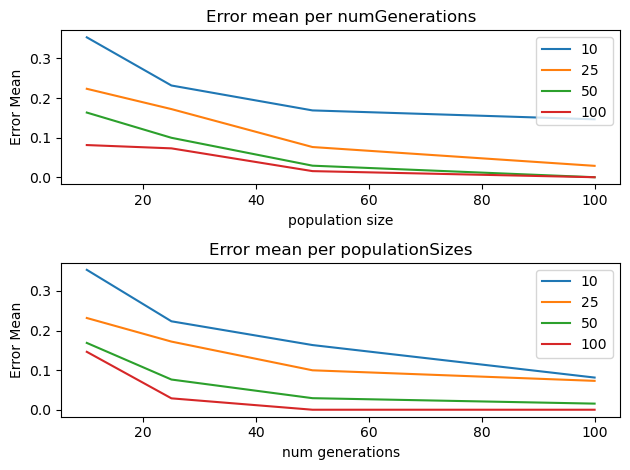

In [ ]:
fig, graphs = plt.subplots(2)

for i in range(len(numGenerations)):
    graphs[0].plot(populationSizes, results[:,i][0], label=numGenerations[i])
    graphs[1].plot(numGenerations, results[i,:][0],label=populationSizes[i])

graphs[0].set_title("Error mean per numGenerations")
graphs[1].set_title("Error mean per populationSizes")

for i, graph in enumerate(graphs.flat):
    graph.set(xlabel=labels[i], ylabel="Error Mean")
    graph.legend()

plt.tight_layout()
plt.show()

Analizando las gráficas, se puede observar que se consiguen mejores resultados cuantos más individuos tenga la población y más generaciones sucedan. La cuestión está en saber cuál es el óptimo valor de cada uno para el problema que se necesite resolver, para evitar pérdidas de tiempo en entrenamientos.

En este caso, podemos ver que para XOR la mejor población está entre los 50 y 100 individuos, donde ya 50 individuos se acerca bastante al error 0; y el mejor número de generaciones está entre 50 y 100 también, donde ambos llegan a error 0 cuando la población es de 100 individuos.

Es decir, para XOR la mejor combinación está alrededor de los 60-80 individuos y alrededor de las 60-70 generaciones. Aunque hemos de remarcar que también depende de la inicialización de la población y de los valores del máximo número de reglas, la probabilidad de mutación, el porcentaje de progenitores y el porcentaje de elitismo. Todas estas variables han de ser optimizadas para cada problema, ya que permiten llegar a los mejores individuos lo más rápido posible.

El porcentaje de progenitores creemos que es la más importante, ya que permite evolucionar rápido; pero no debe ser excesivo, ya que en cada generación habría una población totalmente distinta a la anterior, por lo que el cálculo de fitness no estaría sirviendo de mucho. Creemos que un porcentaje de un 50-60% es más que suficiente.

El elitismo también tiene su importancia, ya que perpetúa a los mejores individuos evitando perder reglas que pueden ser valiosas. Además de que estos no se pierden, pueden seguir generando descendencia, lo que aumenta las posibilidades de obtener mejores descendientes.

La probabilidad de mutación y el número máximo de variables tienen su importancia como el resto, pero creemos que son valores que simplemente tienes que controlar un mínimo y es suficiente. Está claro que un mayor número de reglas por individuo, mejoraría las posibilidades de encontrar mejores reglas, mejorando por tanto su fitness. La probabilidad de mutación es más de lo mismo, tiene que tener un mínimo pero tampoco puede ser muy alto, ya que estaría quitando sentido al fitness y dejando el entrenamiento en manos del azar.